In [1]:
#import libraries
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mne
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

Plan de match
1. Loader les données et faire le nettoyage
2. Visualisation
3. Entraîner le modèle SVM
4. Valider le modèle (fonction objectif, indices de classification, recall, ROC-AUC, etc...)

In [2]:
def load_eeg_csv(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not csv_files:
        raise ValueError(f"No CSV files found in {folder_path}")

    df_list = [pd.read_csv(file).assign(source_file=os.path.basename(file)) for file in csv_files]
    df = pd.concat(df_list, ignore_index=True)

    return df

aya =  r"C:\Users\Leandre Sabourin\git\machine-learning\Paper ayahuasca\Data\Ayahuasca" # User-defined path
noaya = r"C:\Users\Leandre Sabourin\git\machine-learning\Paper ayahuasca\Data\No ayahuasca"
eeg_data_aya = load_eeg_csv(aya)
eeg_data_noaya = load_eeg_csv(noaya)

print(eeg_data_aya.head())

        Fp1        Fz        F3        F7       FT9       FC5       FC1  \
0  1.000000  0.739844  0.612156  0.689476 -0.205708  0.135121  0.520859   
1  0.739844  1.000000  0.570196  0.956244 -0.012145  0.257144  0.787081   
2  0.612156  0.570196  1.000000  0.406135 -0.056610  0.243151  0.278875   
3  0.689476  0.956244  0.406135  1.000000  0.043813  0.230066  0.869191   
4 -0.205708 -0.012145 -0.056610  0.043813  1.000000 -0.062513  0.166707   

         C3        T7       TP9  ...       FT8        F6        F2       AF4  \
0 -0.145334  0.207892 -0.016113  ...  0.383332  0.432619  0.269916  0.500665   
1  0.019417  0.366373 -0.276294  ...  0.090765  0.486036  0.267748  0.206686   
2  0.345840 -0.081579  0.271429  ...  0.238834  0.146138 -0.100036  0.146959   
3  0.010626  0.463175 -0.366635  ...  0.081692  0.534998  0.430763  0.182244   
4  0.242903 -0.100913  0.005839  ... -0.045209  0.066241  0.058335 -0.212188   

        AF8        O2        P4        C6        C2  source_file  
0

Prepare the data and the labels

In [3]:

le = LabelEncoder()


eeg_data_aya["label"] = "yes"
eeg_data_noaya["label"] = "no"
df = pd.concat([eeg_data_aya, eeg_data_noaya], ignore_index=True)
X = df.drop(columns=["label"])  # All EEG channels as features
X = X.select_dtypes(include=['float64', 'float32'])

X = X.astype(float)
Y = df["label"]  # Labels
Y = le.fit_transform(Y)


print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")




Shape of X: (9072, 63)
Shape of Y: (9072,)


Visualisation des données

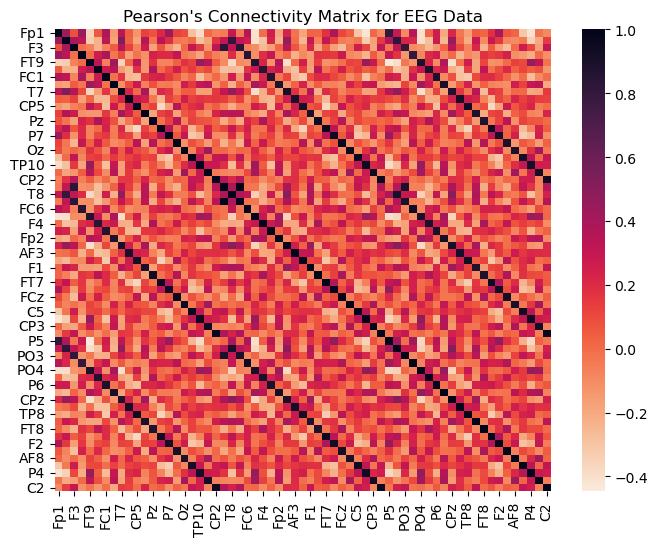

In [4]:
correlation_matrix = X.corr()

# Visualize the Pearson correlation matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, fmt='',cmap='rocket_r')

plt.title("Pearson's Connectivity Matrix for EEG Data")
plt.show()

Train the dataset 

In [5]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
y_combined = y_combined.astype(np.int_)


svm = SVC(kernel='rbf', C=10, gamma ='scale', random_state=1)
svm.fit(X_train, y_train)




SVC(C=10, random_state=1)

PCA visualization

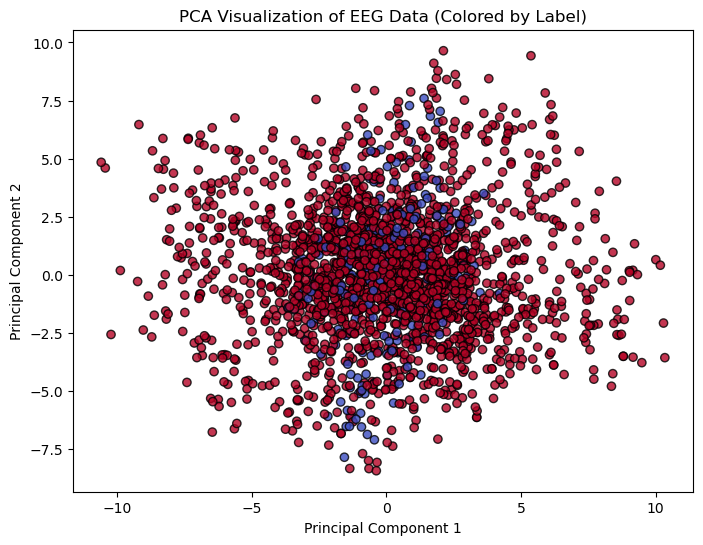

In [12]:
# Reduce EEG features to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Retrain SVM on PCA-reduced features
svm.fit(X_train_pca, y_train)
y_pred_pca = svm.predict(X_test_pca)

# Plot PCA-transformed EEG data
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of EEG Data (Colored by Label)")
plt.show()

Évaluer l'efficacité du SVM

Accuracy: 0.90


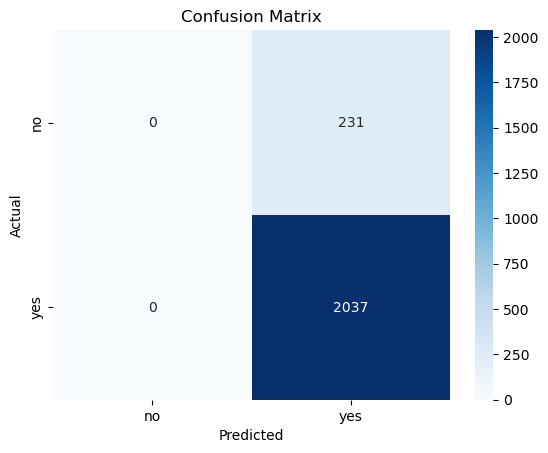

In [15]:
Y_pred = svm.predict(X_test_pca)
accuracy = accuracy_score(y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Grid_searchCV

In [16]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.1, 1, 10],
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
